# Hierarchical Bayesian Modeling of CD8+ T-cell Exhaustion Dynamics in Cancer Using scRNA-seq Data and Markov Chain Monte Carlo

# Part 2: Single-Cell Gene Expression Probability Distribution

## Getting Started

#### Importing Libraries

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import shutil
import requests
import re
from io import StringIO
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.special import factorial

#### Dataset

In [2]:
# loading data
file_path = './dataset/cd8_adata.h5ad'
cd8_adata = sc.read_h5ad(file_path)

In [3]:
# Check the structure of AnnData object
print(cd8_adata)
print("Layers available:", cd8_adata.layers.keys())

AnnData object with n_obs × n_vars = 6557 × 55737
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
Layers available: KeysView(Layers with keys: )


## Exploration

In [4]:
# Extract raw TIGIT counts from the dataset
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten()

# Ensure the counts are integers
raw_counts = np.round(raw_counts).astype(int)

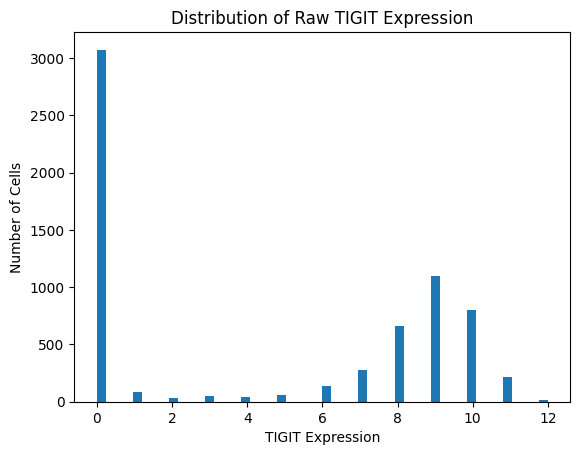

In [5]:
# Plot the distribution of TIGIT expression values
plt.hist(raw_counts, bins=50)
plt.xlabel('TIGIT Expression')
plt.ylabel('Number of Cells')
plt.title('Distribution of Raw TIGIT Expression')
plt.show()

## Other trials

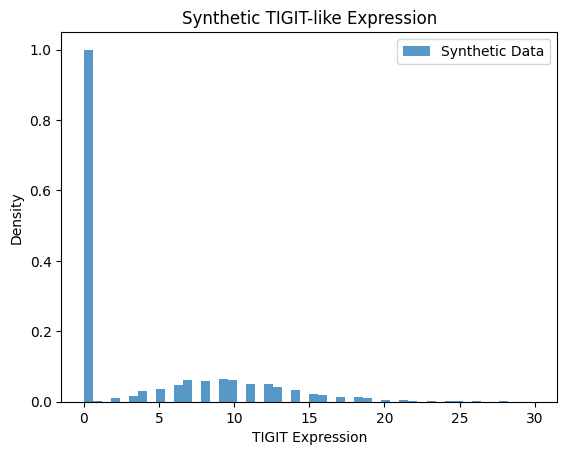

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, poisson

# Parameters for the synthetic ZINB distribution
n = 10  # Number of trials (for negative binomial)
p = 0.5  # Success probability (for negative binomial)
pi_zero = 0.6  # Proportion of zero inflation

# Generate synthetic TIGIT-like expression data
np.random.seed(42)
size = 10000  # Number of cells

# Simulate zero-inflated negative binomial
non_zero_data = nbinom.rvs(n, p, size=size)
zero_data = np.random.choice([0, 1], size=size, p=[pi_zero, 1 - pi_zero])
synthetic_data = zero_data * non_zero_data

# Plot the synthetic TIGIT-like distribution
plt.hist(synthetic_data, bins=50, density=True, alpha=0.75, label="Synthetic Data")
plt.xlabel("TIGIT Expression")
plt.ylabel("Density")
plt.title("Synthetic TIGIT-like Expression")
plt.legend()
plt.show()


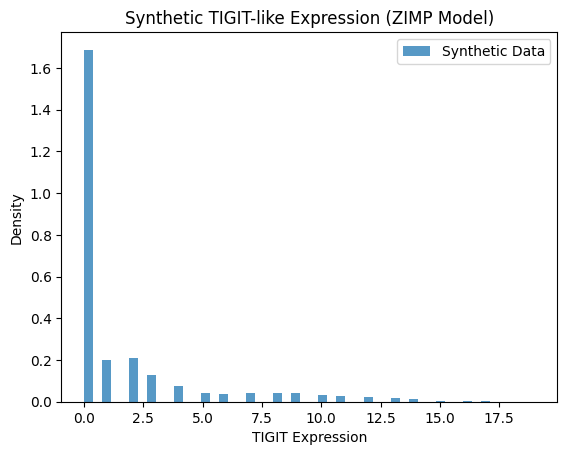

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters for the ZIMP model
pi_zero = 0.6  # Proportion of zero inflation
mix_proportions = [0.7, 0.3]  # Mixture proportions for Poisson components
lambdas = [2, 9]  # Poisson means for each component

# Generate synthetic data
size = 10000  # Total number of cells

# Zero-inflation component
zero_inflation = np.random.choice([0, 1], size=size, p=[pi_zero, 1 - pi_zero])

# Mixture Poisson component
non_zero_indices = np.where(zero_inflation == 1)[0]
poisson_component = np.random.choice(
    len(lambdas), size=len(non_zero_indices), p=mix_proportions
)
synthetic_non_zero = [
    poisson.rvs(mu=lambdas[component]) for component in poisson_component
]

# Combine zero and non-zero components
synthetic_data = np.zeros(size, dtype=int)
synthetic_data[non_zero_indices] = synthetic_non_zero

# Plot the synthetic TIGIT-like distribution
plt.hist(synthetic_data, bins=50, density=True, alpha=0.75, label="Synthetic Data")
plt.xlabel("TIGIT Expression")
plt.ylabel("Density")
plt.title("Synthetic TIGIT-like Expression (ZIMP Model)")
plt.legend()
plt.show()

## Zero-Inflated Poisson Model

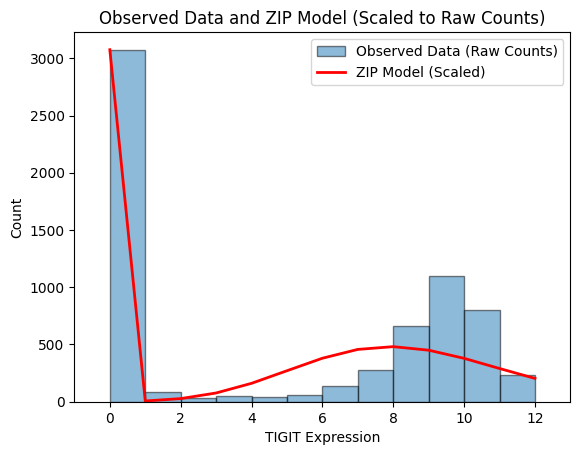

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Observed data
raw_counts = np.round(cd8_adata[:, 'TIGIT'].X.flatten()).astype(int)

# Estimate ZIP parameters
pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
lambda_poisson = raw_counts[raw_counts > 0].mean()  # Mean of non-zero counts

# Define the ZIP PMF
def zip_pmf(x, pi_zero, lambda_poisson):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.exp(-lambda_poisson)
    else:
        return (1 - pi_zero) * poisson.pmf(x, lambda_poisson)

# Generate the ZIP curve
x_values = np.arange(0, raw_counts.max() + 1)
zip_probs = [zip_pmf(x, pi_zero, lambda_poisson) for x in x_values]

# Histogram with raw counts
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)

# Scale ZIP probabilities to match histogram
zip_probs_scaled = np.array(zip_probs) * raw_counts.size * bin_width

# Plot the histogram
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")

# Overlay the scaled ZIP curve
plt.plot(x_values, zip_probs_scaled, 'r-', label="ZIP Model (Scaled)", linewidth=2)

# Labels and legend
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and ZIP Model (Scaled to Raw Counts)")
plt.legend()
plt.xlim(-1, 13)
plt.show()


## Zero-Inflated Mixture Poisson Model

### TIGIT

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12036.217880681521
            Iterations: 41
            Function evaluations: 277
            Gradient evaluations: 41
Final Log-Likelihood: -12036.217880681521
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.36315220345798166
Mixture Proportions (pi_m): [0.18937807 0.81062193]
Poisson Means (lambda_m): [0.05188258 8.13791071]


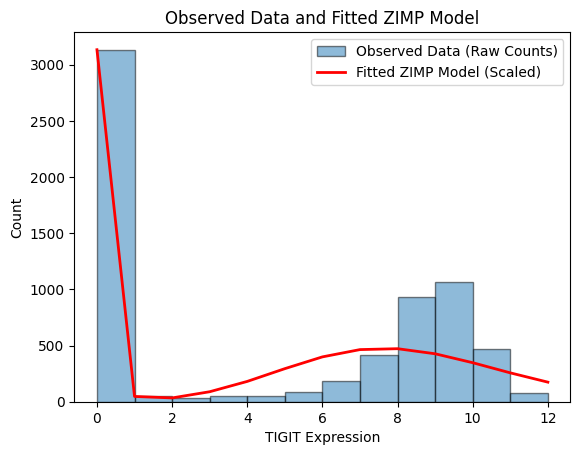

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten().astype(int)

# Define the ZIMP log-likelihood function with debugging
def zimp_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    lambdas = params[M+1:]

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(lambdas <= 0):
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * np.exp(-np.array(lambdas))
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * poisson.pmf(x, np.array(lambdas))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Poisson components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_lambdas = [2, 8]  # Observed peaks in the histogram

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_lambdas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M  # Bounds for pi_0, pi_m, and lambda_m

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimp_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
lambdas_est = result.x[M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Poisson Means (lambda_m): {lambdas_est}")

# Generate the ZIMP curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimp_pmf(x, pi_zero, mix_proportions, lambdas):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * np.exp(-np.array(lambdas))
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * poisson.pmf(x, np.array(lambdas))
        )

zimp_probs = [zimp_pmf(x, pi_zero_est, mix_proportions_est, lambdas_est) for x in x_values]

# Scale ZIMP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimp_probs_scaled = np.array(zimp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimp_probs_scaled, 'r-', label="Fitted ZIMP Model (Scaled)", linewidth=2)
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMP Model")
plt.legend()
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27619D+04    |proj g|=  3.19442D+01

At iterate    1    f=  1.26274D+04    |proj g|=  2.18091D+01

At iterate    2    f=  1.24256D+04    |proj g|=  9.34823D+00

At iterate    3    f=  1.24121D+04    |proj g|=  9.48248D+00

At iterate    4    f=  1.24102D+04    |proj g|=  9.42475D+00

At iterate    5    f=  1.24097D+04    |proj g|=  9.44854D+00

At iterate    6    f=  1.24084D+04    |proj g|=  9.46867D+00

At iterate    7    f=  1.24042D+04    |proj g|=  9.56619D+00

At iterate    8    f=  1.23948D+04    |proj g|=  5.40112D+00

At iterate    9    f=  1.23889D+04    |proj g|=  4.03634D+00

At iterate   10    f=  1.23840D+04    |proj g|=  9.68193D+00

At iterate   11    f=  1.23837D+04    |proj g|=  7.76527D+00

At iterate   12    f=  1.23836D+04    |proj g|=  7.68323D+00

At iterate   13    f=  1.2

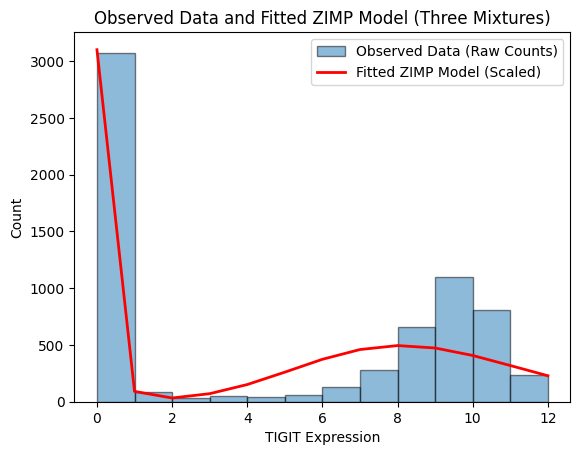

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten().astype(int)

# Define the ZIMP log-likelihood function with debugging and regularization
def zimp_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    lambdas = params[M+1:]

    # Normalize proportions
    mix_proportions /= mix_proportions.sum()

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(lambdas <= 0):
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * np.exp(-np.array(lambdas))
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * poisson.pmf(x, np.array(lambdas))
            )
        # Regularize probabilities to avoid log(0)
        prob = max(prob, 1e-10)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Initial guesses for parameters
M = 3  # Number of Poisson components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.1, 0.05, 0.85]  # Adjusted proportions
initial_lambdas = [2, 6, 10]  # Observed peaks in the histogram

# Update the initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_lambdas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M  # Bounds for pi_0, pi_m, and lambda_m

# Optimize with updated initial guesses using L-BFGS-B
result = minimize(
    zimp_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    method='L-BFGS-B',  # Use L-BFGS-B optimization method
    options={'disp': True, 'maxiter': 1000}  # Set max iterations and enable debugging output
)


# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
lambdas_est = result.x[M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Poisson Means (lambda_m): {lambdas_est}")

# Generate the ZIMP curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimp_pmf(x, pi_zero, mix_proportions, lambdas):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * np.exp(-np.array(lambdas))
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * poisson.pmf(x, np.array(lambdas))
        )

zimp_probs = [zimp_pmf(x, pi_zero_est, mix_proportions_est, lambdas_est) for x in x_values]

# Scale ZIMP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimp_probs_scaled = np.array(zimp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimp_probs_scaled, 'r-', label="Fitted ZIMP Model (Scaled)", linewidth=2)
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMP Model (Three Mixtures)")
plt.legend()
plt.show()

## Zero-Inflated Mixture Negative Binomial Model

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12040.948563723521
            Iterations: 42
            Function evaluations: 326
            Gradient evaluations: 42
Final Log-Likelihood: -12040.948563723521
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.43576152985084876
Mixture Proportions (pi_m): [0.91409578 0.08590422]
Negative Binomial Means (mu): [8.14554333 0.13739236]
Dispersion Parameter (r): 1967.7382137146722


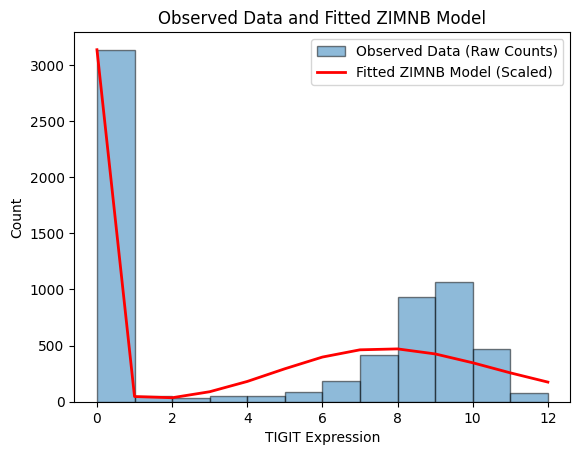

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model")
plt.legend()
plt.show()

# ZIGP

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50819D+04    |proj g|=  2.11873D+03

At iterate    1    f=  1.34443D+04    |proj g|=  1.20224D+03

At iterate    2    f=  1.23289D+04    |proj g|=  3.72208D+02

At iterate    3    f=  1.19956D+04    |proj g|=  5.28711D+01

At iterate    4    f=  1.17115D+04    |proj g|=  1.01173D+01

At iterate    5    f=  1.16219D+04    |proj g|=  4.45323D+02

At iterate    6    f=  1.14312D+04    |proj g|=  2.45389D+01

At iterate    7    f=  1.14236D+04    |proj g|=  9.05074D+00

At iterate    8    f=  1.14236D+04    |proj g|=  7.85421D+00

At iterate    9    f=  1.14222D+04    |proj g|=  1.72675D+00

At iterate   10    f=  1.14222D+04    |proj g|=  8.22183D-02

At iterate   11    f=  1.14222D+04    |proj g|=  2.60115D-02
Final Log-Likelihood: -11422.189227189561
At iterate   12    f=  1.14222D+04    |proj g|=

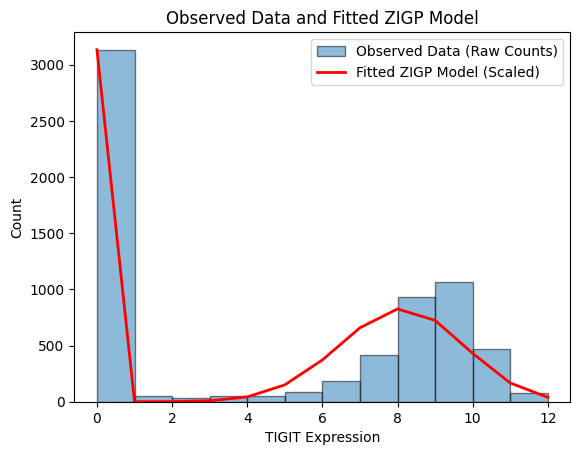

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson PMF
def zigp_pmf(x, pi, lambd, theta):
    if x == 0:
        return pi + (1 - pi) * generalized_poisson_pmf(0, lambd, theta)
    else:
        return (1 - pi) * generalized_poisson_pmf(x, lambd, theta)

# Log-likelihood function for ZIGP
def zigp_log_likelihood(params, data):
    pi, lambd, theta = params
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or lambd <= 0 or not (-1 < theta < 1):
        return np.inf  # Penalize invalid parameters
    log_likelihood = 0
    for x in data:
        prob = zigp_pmf(x, pi, lambd, theta)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Initial parameter guesses
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_lambd = raw_counts.mean()  # Mean of data
initial_theta = 0.1  # Small dispersion value
initial_params = [initial_pi, initial_lambd, initial_theta]

# Bounds for the parameters
bounds = [(0, 1), (1e-5, None), (-0.99, 0.99)]

# Optimize the log-likelihood
result = minimize(
    zigp_log_likelihood,
    initial_params,
    args=(raw_counts,),
    bounds=bounds,
    method='L-BFGS-B',
    options={'disp': True}
)

# Extract optimized parameters
pi_est, lambd_est, theta_est = result.x

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Generalized Poisson Rate (lambda): {lambd_est}")
print(f"Dispersion Parameter (theta): {theta_est}")

# Generate the ZIGP PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_pmf(x, pi_est, lambd_est, theta_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Model (Scaled)", linewidth=2)
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Model")
plt.legend()
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10891.215314244424
            Iterations: 33
            Function evaluations: 300
            Gradient evaluations: 33
Final Log-Likelihood: -10891.215314244424
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.47542440436470834
Mixture Proportions (weights): [0.05754958 0.94245042]
Generalized Poisson Rates (lambdas): [ 2.53855002 16.49846884]
Dispersion Parameters (thetas): [ 0.01222583 -0.99      ]


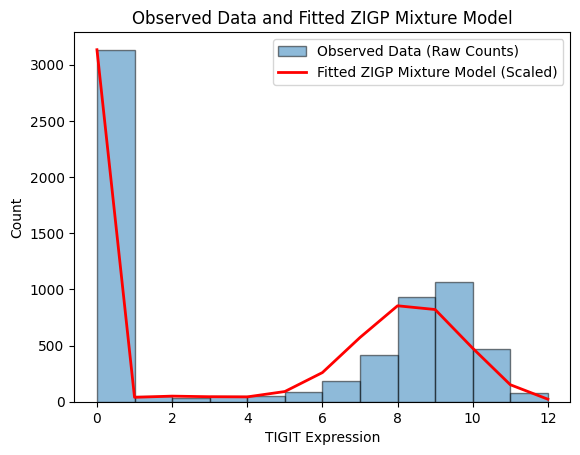

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()


## INFG

#### ZIMP

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10392.900878225326
            Iterations: 33
            Function evaluations: 225
            Gradient evaluations: 33
Final Log-Likelihood: -10392.900878225326
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.5755064159646419
Mixture Proportions (pi_m): [0.07499804 0.92500196]
Poisson Means (lambda_m): [0.25456056 8.36138126]


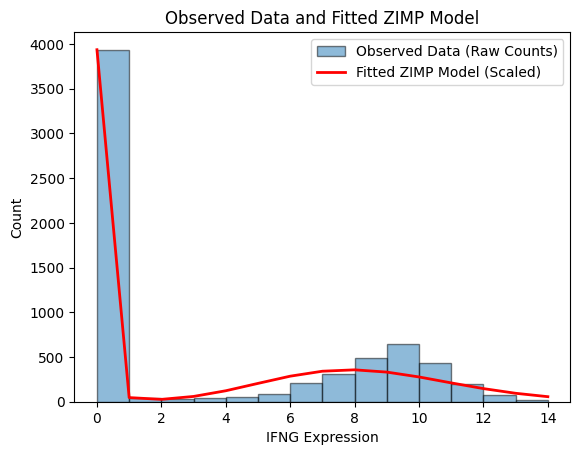

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'IFNG'].X.flatten().astype(int)

# Define the ZIMP log-likelihood function with debugging
def zimp_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    lambdas = params[M+1:]

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(lambdas <= 0):
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * np.exp(-np.array(lambdas))
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * poisson.pmf(x, np.array(lambdas))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Poisson components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_lambdas = [2, 8]  # Observed peaks in the histogram

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_lambdas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M  # Bounds for pi_0, pi_m, and lambda_m

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimp_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
lambdas_est = result.x[M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Poisson Means (lambda_m): {lambdas_est}")

# Generate the ZIMP curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimp_pmf(x, pi_zero, mix_proportions, lambdas):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * np.exp(-np.array(lambdas))
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * poisson.pmf(x, np.array(lambdas))
        )

zimp_probs = [zimp_pmf(x, pi_zero_est, mix_proportions_est, lambdas_est) for x in x_values]

# Scale ZIMP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimp_probs_scaled = np.array(zimp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimp_probs_scaled, 'r-', label="Fitted ZIMP Model (Scaled)", linewidth=2)
plt.xlabel("IFNG Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMP Model")
plt.legend()
plt.show()

#### ZIMNB

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10402.915983047986
            Iterations: 49
            Function evaluations: 387
            Gradient evaluations: 49
Final Log-Likelihood: -10402.915983047986
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.5688972045854819
Mixture Proportions (pi_m): [0.0885381 0.9114619]
Negative Binomial Means (mu): [0.20236867 8.35672828]
Dispersion Parameter (r): 559.7756809587212


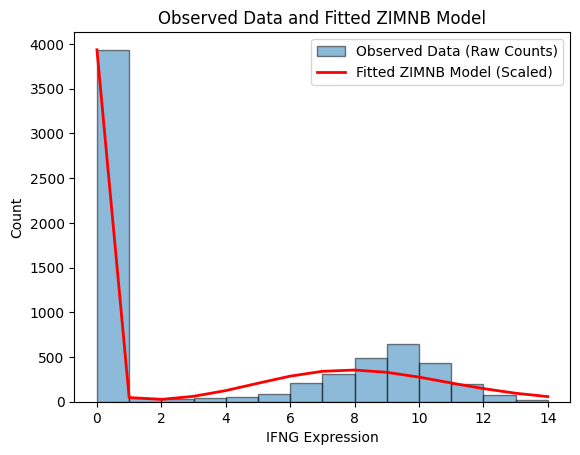

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize

# Observed data for IFNG
raw_counts = cd8_adata[:, 'IFNG'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("IFNG Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model")
plt.legend()
plt.show()

Iteration limit reached    (Exit mode 9)
            Current function value: 10399.714622002097
            Iterations: 100
            Function evaluations: 965
            Gradient evaluations: 100
Final Log-Likelihood: -10399.714622002097
Optimization Success: False
Optimization Message: Iteration limit reached
Estimated Parameters:
Zero Inflation (pi_0): 0.5735897616393957
Mixture Proportions (pi_m): [9.21106917e-01 7.88930827e-02 8.13355524e-13]
Negative Binomial Means (mu): [8.35936682 0.23502494 5.69325061]
Dispersion Parameter (r): 823.0860533262007


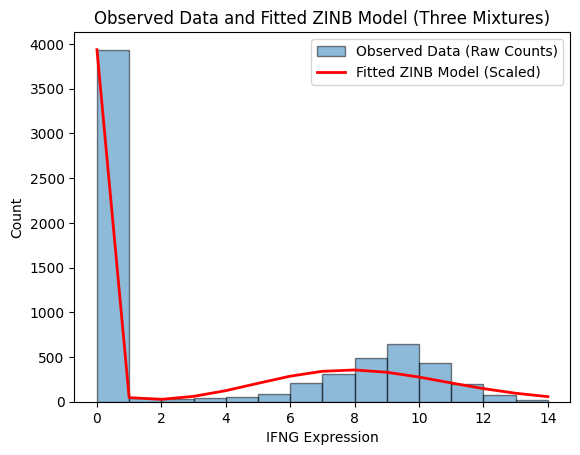

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'IFNG'].X.flatten().astype(int)

# Define the ZINB log-likelihood function
def zinb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 3  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.5, 0.3, 0.2]  # Adjusted proportions
initial_mus = [2, 6, 12]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zinb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZINB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zinb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zinb_probs = [zinb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZINB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zinb_probs_scaled = np.array(zinb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZINB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zinb_probs_scaled, 'r-', label="Fitted ZINB Model (Scaled)", linewidth=2)
plt.xlabel("IFNG Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZINB Model (Three Mixtures)")
plt.legend()
plt.show()

## TCF7

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7839.091021129285
            Iterations: 23
            Function evaluations: 190
            Gradient evaluations: 23
Final Log-Likelihood: -7839.091021129285
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.7213758963372856
Mixture Proportions (pi_m): [0.01511687 0.98488313]
Negative Binomial Means (mu): [5.8659837 5.835171 ]
Dispersion Parameter (r): 899.7164129865758


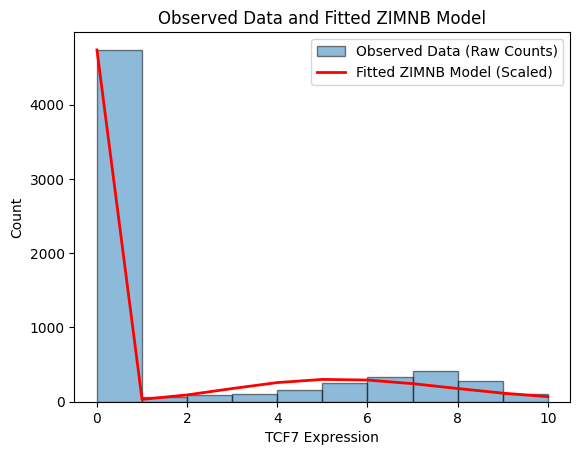

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize

# Observed data for TCF7
raw_counts = cd8_adata[:, 'TCF7'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("TCF7 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model")
plt.legend()
plt.show()

## SELL

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5711.881325938131
            Iterations: 24
            Function evaluations: 189
            Gradient evaluations: 24
Final Log-Likelihood: -5711.881325938131
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.8341682160241303
Mixture Proportions (pi_m): [0.67907216 0.32092784]
Negative Binomial Means (mu): [7.25090986 7.2583266 ]
Dispersion Parameter (r): 38.847295441366576


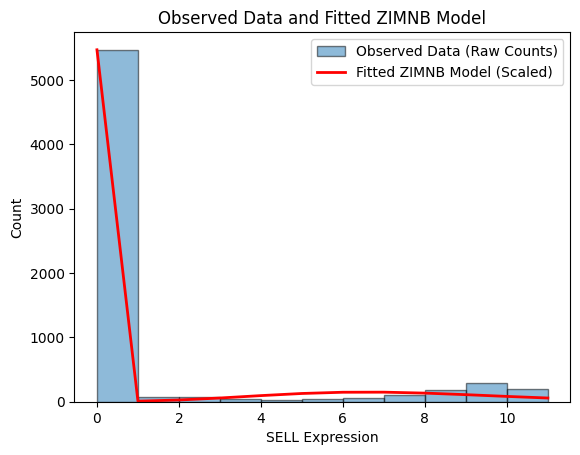

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize

# Observed data for SELL
raw_counts = cd8_adata[:, 'SELL'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("SELL Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model")
plt.legend()
plt.show()


## PRF1

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14745.476548023182
            Iterations: 20
            Function evaluations: 160
            Gradient evaluations: 20
Final Log-Likelihood: -14745.476548023182
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.279629135519411
Mixture Proportions (pi_m): [8.80405147e-12 1.00000000e+00]
Negative Binomial Means (mu): [23.70666252  8.47984481]
Dispersion Parameter (r): 1224.7725646738784


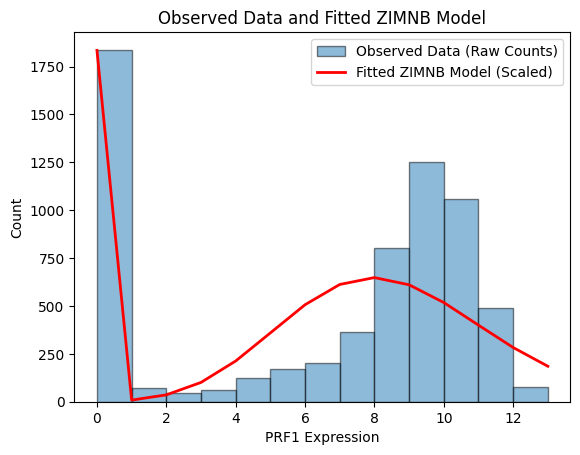

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize

# Observed data for SELL
raw_counts = cd8_adata[:, 'PRF1'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("PRF1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model")
plt.legend()
plt.show()

## Zero-Inflated Generalized Poisson Mixture Model

## TIGIT

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10891.215314244424
            Iterations: 33
            Function evaluations: 300
            Gradient evaluations: 33
Final Log-Likelihood: -10891.215314244424
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.47542440436470834
Mixture Proportions (weights): [0.05754958 0.94245042]
Generalized Poisson Rates (lambdas): [ 2.53855002 16.49846884]
Dispersion Parameters (thetas): [ 0.01222583 -0.99      ]


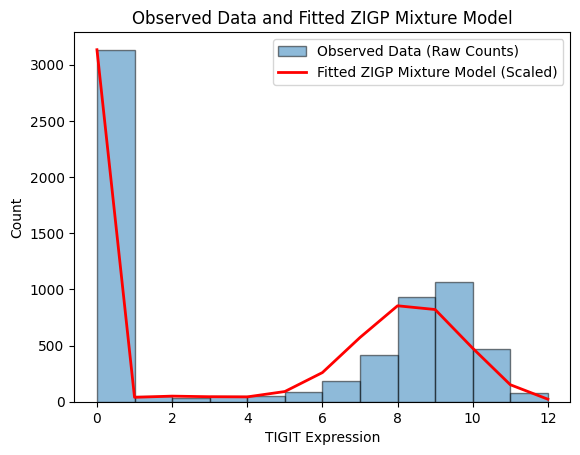

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data
raw_counts = cd8_adata[:, 'TIGIT'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("TIGIT Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()


## IFNG

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9964.63311884299
            Iterations: 25
            Function evaluations: 228
            Gradient evaluations: 25
Final Log-Likelihood: -9964.63311884299
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5972719176144701
Mixture Proportions (weights): [0.08959756 0.91040244]
Generalized Poisson Rates (lambdas): [ 2.48864183 15.29838249]
Dispersion Parameters (thetas): [ 0.2797896  -0.77129771]


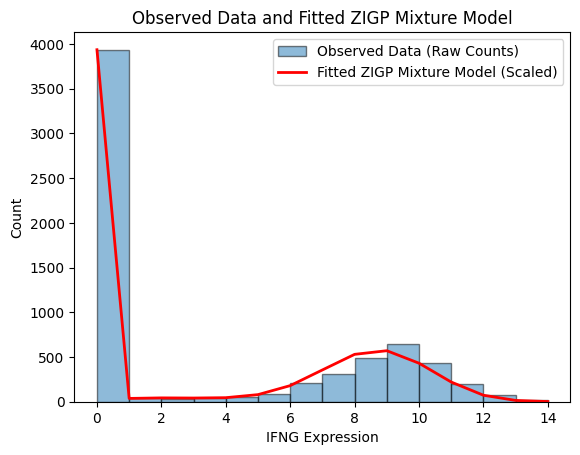

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data for IFNG
raw_counts = cd8_adata[:, 'IFNG'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("IFNG Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()

## SELL

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5272.987003736339
            Iterations: 29
            Function evaluations: 254
            Gradient evaluations: 29
Final Log-Likelihood: -5272.987003736339
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.8280968145132437
Mixture Proportions (weights): [0.24042794 0.75957206]
Generalized Poisson Rates (lambdas): [ 1.86159096 16.86919545]
Dispersion Parameters (thetas): [ 0.11410319 -0.99      ]


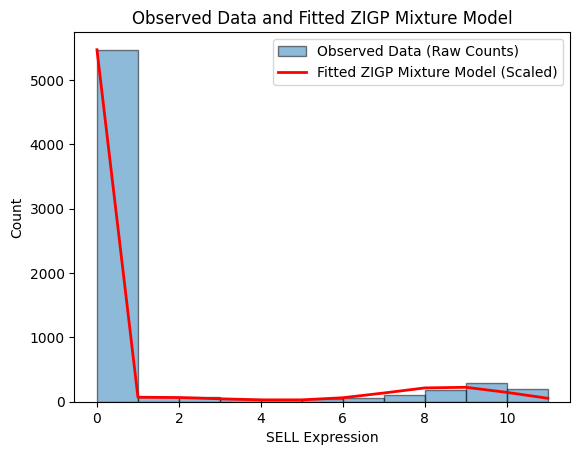

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data for SELL
raw_counts = cd8_adata[:, 'SELL'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("SELL Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()

## PRF1

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13458.674119890191
            Iterations: 27
            Function evaluations: 249
            Gradient evaluations: 27
Final Log-Likelihood: -13458.674119890191
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.2783498589552784
Mixture Proportions (weights): [0.11083585 0.88916415]
Generalized Poisson Rates (lambdas): [ 3.71006623 17.84272052]
Dispersion Parameters (thetas): [ 0.08754977 -0.99      ]


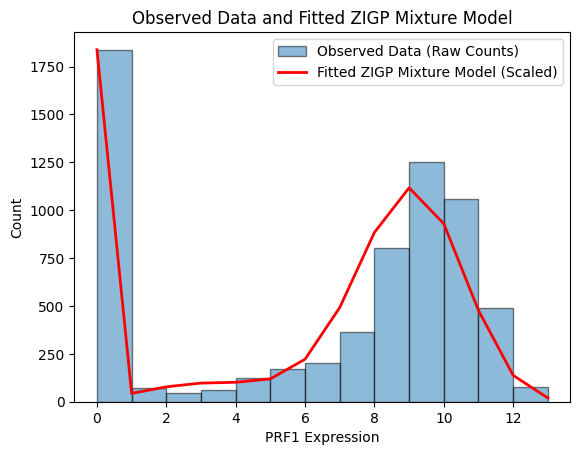

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data for PRF1
raw_counts = cd8_adata[:, 'PRF1'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("PRF1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()

## HAVCR2

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9947.058051648064
            Iterations: 25
            Function evaluations: 226
            Gradient evaluations: 24
Final Log-Likelihood: -9947.058051648064
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5779925608851453
Mixture Proportions (weights): [0.11272558 0.88727442]
Generalized Poisson Rates (lambdas): [ 2.77817007 16.81802073]
Dispersion Parameters (thetas): [-0.05150537 -0.99      ]


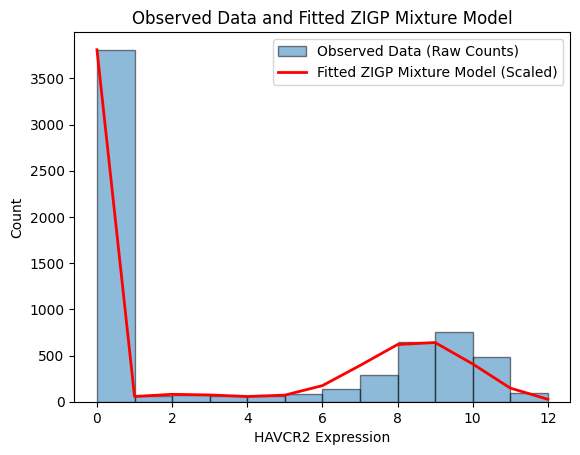

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize

# Observed data for HAVCR2
raw_counts = cd8_adata[:, 'HAVCR2'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("HAVCR2 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()

# Zero-Inflated Generalized Poisson Mixture Model for scRNAseq Gene Expression

In [6]:
def fit_zigp_mixture_model(cd8_adata, gene, M=2, initial_weights=None, initial_lambdas=None, initial_thetas=None):
    """
    Fits a Zero-Inflated Generalized Poisson Mixture Model to the expression data of a specified gene.

    Parameters:
    - cd8_adata: AnnData object containing gene expression data.
    - gene: The name of the gene to fit the model for.
    - M: Number of mixture components (default: 2).
    - initial_weights: Initial guesses for the mixture weights (default: equal proportions).
    - initial_lambdas: Initial guesses for the Generalized Poisson lambda values (default: [2, 8]).
    - initial_thetas: Initial guesses for the Generalized Poisson theta values (default: [0.1, -0.1]).

    Returns:
    - Optimized parameters and a plot showing the fitted model and observed data.
    """
    # Observed data for the specified gene
    raw_counts = cd8_adata[:, gene].X.flatten().astype(int)
    
    # Default initial values
    if initial_weights is None:
        initial_weights = [1/M] * M  # Equal proportions
    if initial_lambdas is None:
        initial_lambdas = np.linspace(2, 8, M)  # Spread observed peaks
    if initial_thetas is None:
        initial_thetas = np.linspace(0.1, -0.1, M)  # Small dispersion values

    # Generalized Poisson PMF
    def generalized_poisson_pmf(x, lambd, theta):
        if x < 0:
            return 0
        term1 = lambd * (lambd + theta * x) ** (x - 1)
        term2 = np.exp(-(lambd + theta * x))
        term3 = factorial(x)
        return term1 * term2 / term3

    # Zero-Inflated Generalized Poisson Mixture PMF
    def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
        if x == 0:
            return pi + (1 - pi) * np.sum(
                weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
            )
        else:
            return (1 - pi) * np.sum(
                weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
            )

    # Log-likelihood function for ZIGPM
    def zigp_mixture_log_likelihood(params, data):
        pi = params[0]
        weights = np.array(params[1:M+1])
        lambdas = params[M+1:2*M+1]
        thetas = params[2*M+1:]
        
        # Normalize weights to ensure they sum to 1
        weights /= np.sum(weights)
        
        # Ensure constraints are satisfied
        if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
            return np.inf  # Penalize invalid parameters
        
        log_likelihood = 0
        for x in data:
            prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
            prob = max(prob, 1e-10)  # Avoid log(0)
            log_likelihood += np.log(prob)
        return -log_likelihood  # Negative for minimization

    # Define the constraint for mixture proportions
    def proportions_constraint(params):
        weights = params[1:M+1]
        return np.sum(weights) - 1

    # Combine initial parameters
    initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
    initial_params = [initial_pi] + initial_weights + initial_lambdas.tolist() + initial_thetas.tolist()

    # Define bounds
    bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

    # Add the constraint for mixture proportions
    constraints = [{'type': 'eq', 'fun': proportions_constraint}]

    # Optimize with constraints
    result = minimize(
        zigp_mixture_log_likelihood,
        initial_params,
        args=(raw_counts,),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP',  # Use SLSQP optimization method
        options={'disp': True}  # Enable debugging output
    )

    # Extract optimized parameters
    pi_est = result.x[0]
    weights_est = result.x[1:M+1]
    lambdas_est = result.x[M+1:2*M+1]
    thetas_est = result.x[2*M+1:]

    # Debugging log-likelihood
    print(f"Final Log-Likelihood: {-result.fun}")
    print("Optimization Success:", result.success)
    print("Optimization Message:", result.message)
    print("Estimated Parameters:")
    print(f"Zero Inflation (pi): {pi_est}")
    print(f"Mixture Proportions (weights): {weights_est}")
    print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
    print(f"Dispersion Parameters (thetas): {thetas_est}")

    # Generate the ZIGPM PMF curve
    x_values = np.arange(0, raw_counts.max() + 1)
    zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

    # Scale ZIGP probabilities to match histogram
    bin_width = 1  # Bin width for histogram
    bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
    hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
    zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

    # Plot the histogram and ZIGP model
    plt.hist(raw_counts, bins=bins, alpha=0.5, label=f"Observed Data ({gene} Raw Counts)", edgecolor="black")
    plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
    plt.xlabel(f"{gene} Expression")
    plt.ylabel("Count")
    plt.title(f"Observed Data and Fitted ZIGP Mixture Model for {gene}")
    plt.legend()
    plt.show()

    # Return the results
    return {
        "pi": pi_est,
        "weights": weights_est,
        "lambdas": lambdas_est,
        "thetas": thetas_est,
        "log_likelihood": -result.fun
    }

Fitting ZIGPM for terminal exhaustion genes...

Processing gene: PDCD1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10297.244729012533
            Iterations: 33
            Function evaluations: 299
            Gradient evaluations: 33
Final Log-Likelihood: -10297.244729012533
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.520921022220038
Mixture Proportions (weights): [0.11214948 0.88785052]
Generalized Poisson Rates (lambdas): [ 1.21760785 16.43115341]
Dispersion Parameters (thetas): [ 0.26096311 -0.99      ]


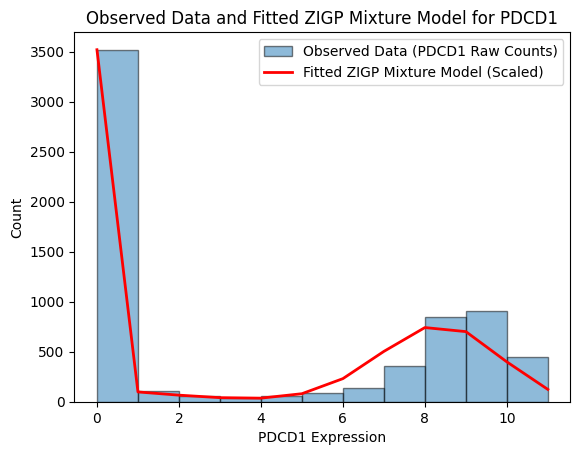


Processing gene: LAG3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9588.666955289742
            Iterations: 23
            Function evaluations: 211
            Gradient evaluations: 23
Final Log-Likelihood: -9588.666955289742
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5959339688505648
Mixture Proportions (weights): [0.18213333 0.81786667]
Generalized Poisson Rates (lambdas): [ 2.11101835 13.8972341 ]
Dispersion Parameters (thetas): [ 0.10917453 -0.99      ]


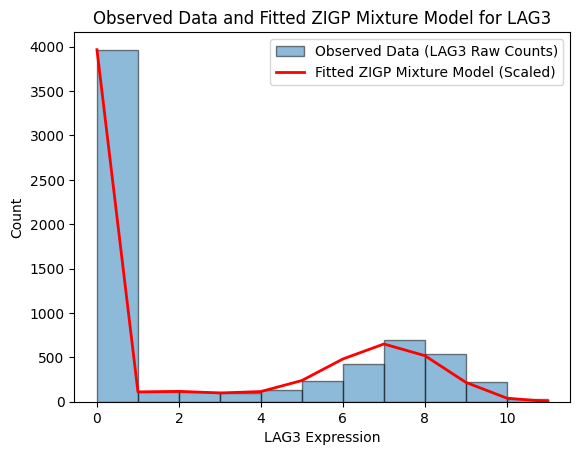


Processing gene: HAVCR2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9947.058051648064
            Iterations: 25
            Function evaluations: 226
            Gradient evaluations: 24
Final Log-Likelihood: -9947.058051648064
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5779925608851453
Mixture Proportions (weights): [0.11272558 0.88727442]
Generalized Poisson Rates (lambdas): [ 2.77817007 16.81802073]
Dispersion Parameters (thetas): [-0.05150537 -0.99      ]


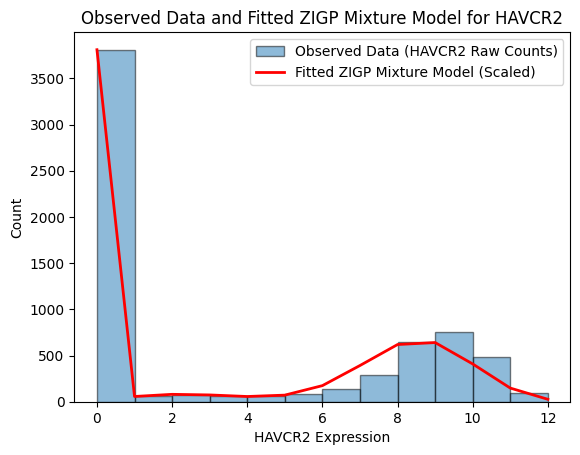


Processing gene: TIGIT
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10891.215314244424
            Iterations: 33
            Function evaluations: 300
            Gradient evaluations: 33
Final Log-Likelihood: -10891.215314244424
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.47542440436470834
Mixture Proportions (weights): [0.05754958 0.94245042]
Generalized Poisson Rates (lambdas): [ 2.53855002 16.49846884]
Dispersion Parameters (thetas): [ 0.01222583 -0.99      ]


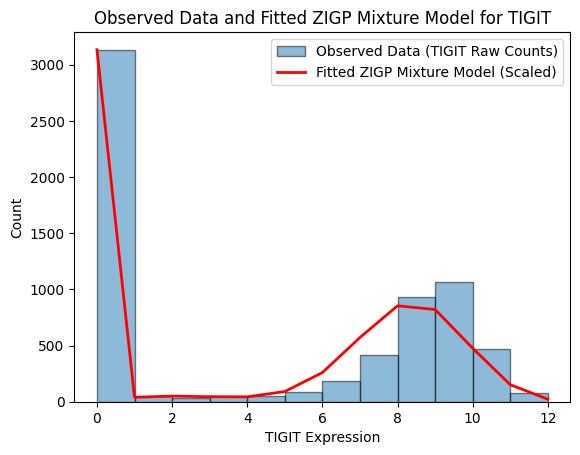


Processing gene: TOX
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10560.917454618455
            Iterations: 24
            Function evaluations: 212
            Gradient evaluations: 23
Final Log-Likelihood: -10560.917454618455
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5493886191663414
Mixture Proportions (weights): [0.34703917 0.65296083]
Generalized Poisson Rates (lambdas): [ 2.89664262 13.11705085]
Dispersion Parameters (thetas): [-6.75790585e-04 -9.90000000e-01]


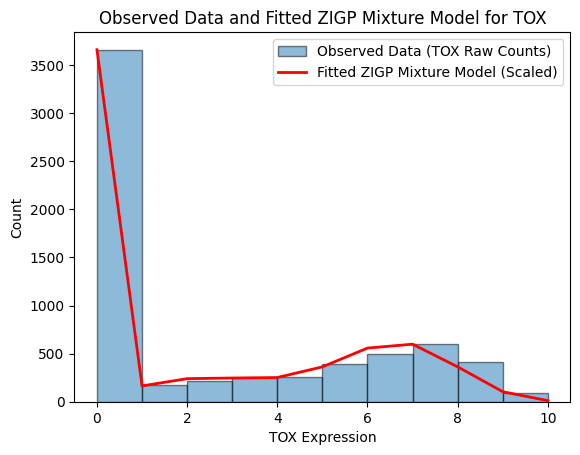


Processing gene: EOMES
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6711.126287189325
            Iterations: 23
            Function evaluations: 215
            Gradient evaluations: 23
Final Log-Likelihood: -6711.126287189325
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7682452023170353
Mixture Proportions (weights): [0.39814154 0.60185846]
Generalized Poisson Rates (lambdas): [ 4.25013059 13.24768539]
Dispersion Parameters (thetas): [-0.07291006 -0.94632124]


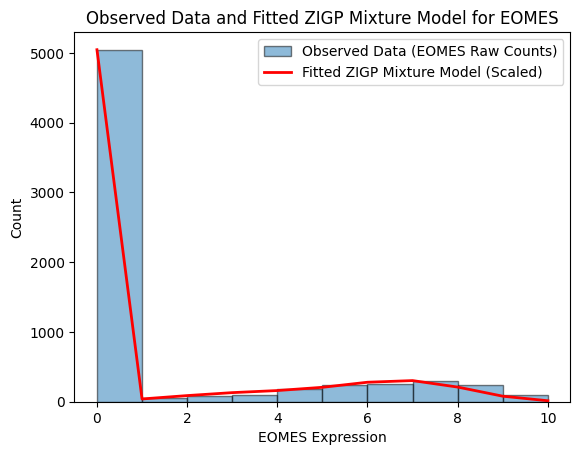


Processing gene: BATF
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8161.5631160950115
            Iterations: 26
            Function evaluations: 223
            Gradient evaluations: 25
Final Log-Likelihood: -8161.5631160950115
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.688626724019109
Mixture Proportions (weights): [0.17497307 0.82502693]
Generalized Poisson Rates (lambdas): [ 2.95122747 16.01758661]
Dispersion Parameters (thetas): [-0.23536926 -0.99      ]


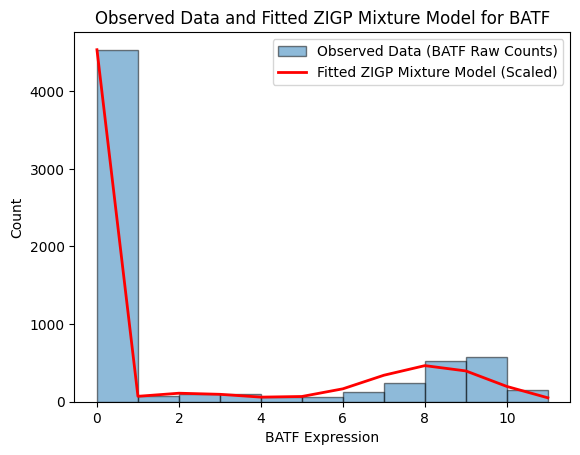


Processing gene: ENTPD1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7705.750133579656
            Iterations: 27
            Function evaluations: 247
            Gradient evaluations: 27
Final Log-Likelihood: -7705.750133579656
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7201476912440196
Mixture Proportions (weights): [0.23234684 0.76765316]
Generalized Poisson Rates (lambdas): [ 3.28189653 15.16488381]
Dispersion Parameters (thetas): [ 0.03999436 -0.99      ]


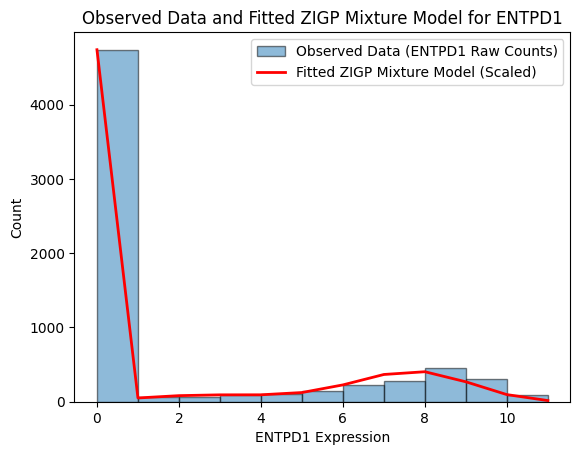


Processing gene: ITGAE
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9829.687637023535
            Iterations: 23
            Function evaluations: 210
            Gradient evaluations: 23
Final Log-Likelihood: -9829.687637023535
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.6043136551288061
Mixture Proportions (weights): [0.1891461 0.8108539]
Generalized Poisson Rates (lambdas): [ 4.05441113 16.48595231]
Dispersion Parameters (thetas): [-0.31648295 -0.99      ]


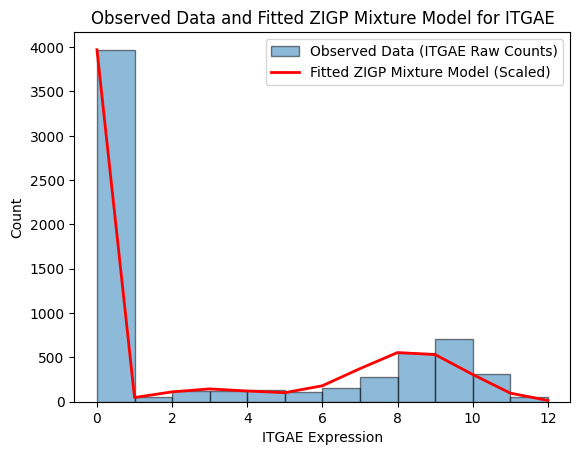


Fitting ZIGPM for progenitor exhaustion genes...

Processing gene: TCF7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7606.79836378414
            Iterations: 21
            Function evaluations: 196
            Gradient evaluations: 21
Final Log-Likelihood: -7606.79836378414
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7197738503224304
Mixture Proportions (weights): [0.2482391 0.7517609]
Generalized Poisson Rates (lambdas): [ 3.2083402  12.62245451]
Dispersion Parameters (thetas): [ 0.0046738  -0.89790986]


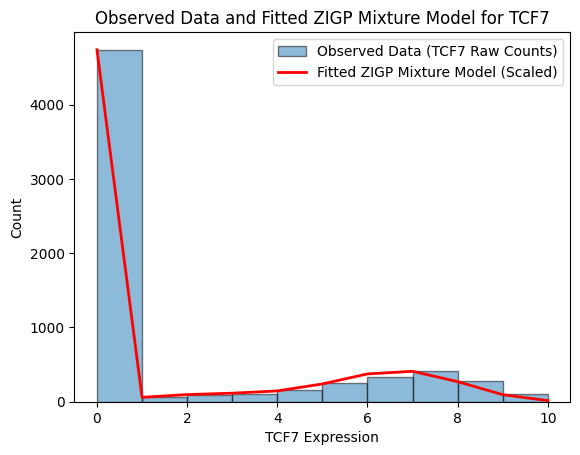


Processing gene: LEF1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2871.9578515063145
            Iterations: 19
            Function evaluations: 173
            Gradient evaluations: 19
Final Log-Likelihood: -2871.9578515063145
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.9227475590873974
Mixture Proportions (weights): [0.28069751 0.71930249]
Generalized Poisson Rates (lambdas): [ 3.44236609 15.94670355]
Dispersion Parameters (thetas): [ 0.0208206 -0.99     ]


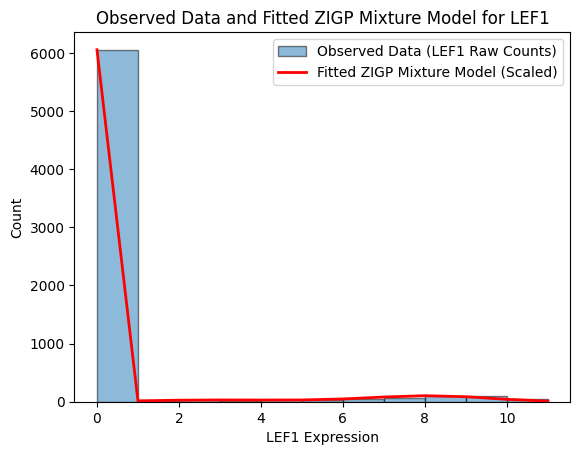


Processing gene: CXCR5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2844.7940490283527
            Iterations: 17
            Function evaluations: 158
            Gradient evaluations: 17
Final Log-Likelihood: -2844.7940490283527
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.9205593937075889
Mixture Proportions (weights): [0.40562254 0.59437746]
Generalized Poisson Rates (lambdas): [ 3.16456388 11.45333492]
Dispersion Parameters (thetas): [-0.02844693 -0.90046946]


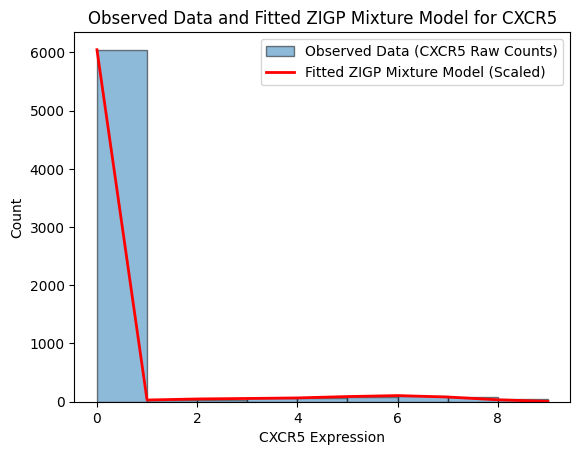


Processing gene: IL7R
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7741.677955046718
            Iterations: 23
            Function evaluations: 213
            Gradient evaluations: 23
Final Log-Likelihood: -7741.677955046718
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7157086793634418
Mixture Proportions (weights): [0.1513924 0.8486076]
Generalized Poisson Rates (lambdas): [ 3.43565529 16.70964562]
Dispersion Parameters (thetas): [ 0.09959288 -0.99      ]


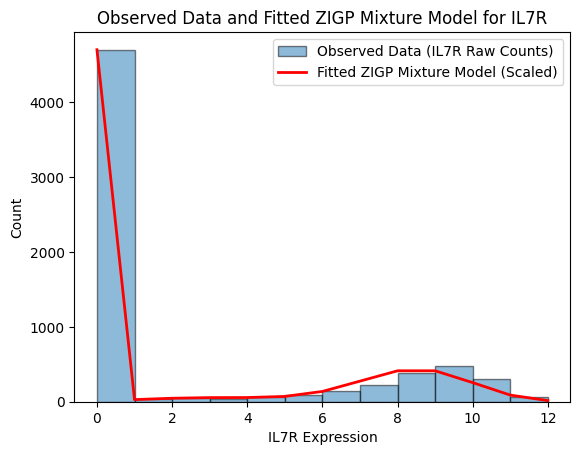


Processing gene: SELL
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5272.987003736339
            Iterations: 29
            Function evaluations: 254
            Gradient evaluations: 29
Final Log-Likelihood: -5272.987003736339
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.8280968145132437
Mixture Proportions (weights): [0.24042794 0.75957206]
Generalized Poisson Rates (lambdas): [ 1.86159096 16.86919545]
Dispersion Parameters (thetas): [ 0.11410319 -0.99      ]


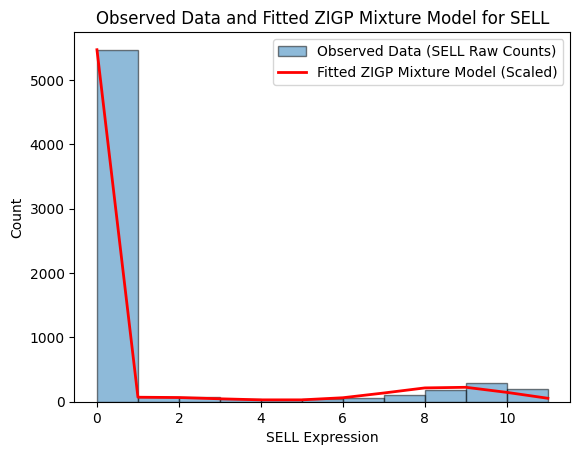


Processing gene: GZMB
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10967.718942569565
            Iterations: 30
            Function evaluations: 270
            Gradient evaluations: 30
Final Log-Likelihood: -10967.718942569565
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.4963217534522062
Mixture Proportions (weights): [0.04571177 0.95428823]
Generalized Poisson Rates (lambdas): [ 3.12644181 19.9358    ]
Dispersion Parameters (thetas): [-0.24033343 -0.99      ]


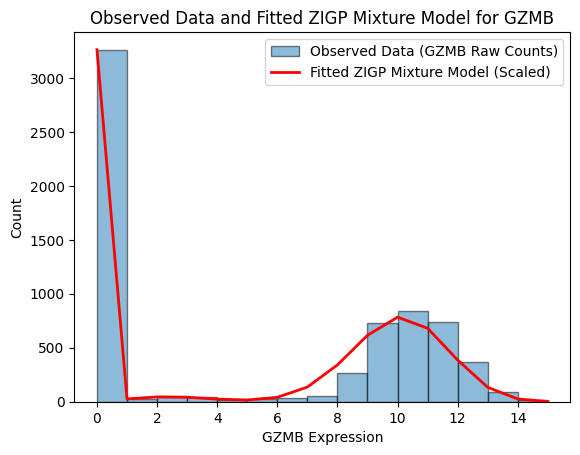


Processing gene: PRF1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13458.674119890191
            Iterations: 27
            Function evaluations: 249
            Gradient evaluations: 27
Final Log-Likelihood: -13458.674119890191
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.2783498589552784
Mixture Proportions (weights): [0.11083585 0.88916415]
Generalized Poisson Rates (lambdas): [ 3.71006623 17.84272052]
Dispersion Parameters (thetas): [ 0.08754977 -0.99      ]


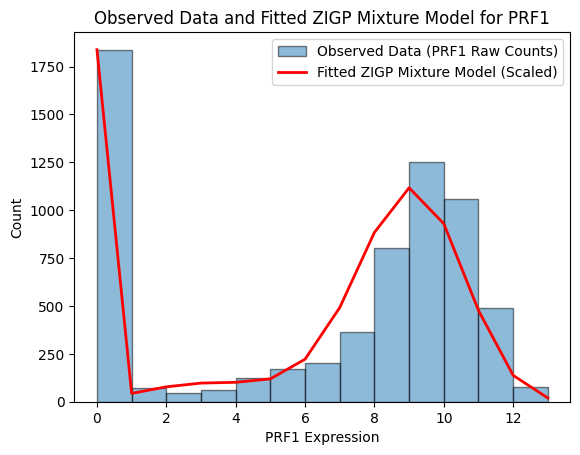


Processing gene: IFNG
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9964.63311884299
            Iterations: 25
            Function evaluations: 228
            Gradient evaluations: 25
Final Log-Likelihood: -9964.63311884299
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5972719176144701
Mixture Proportions (weights): [0.08959756 0.91040244]
Generalized Poisson Rates (lambdas): [ 2.48864183 15.29838249]
Dispersion Parameters (thetas): [ 0.2797896  -0.77129771]


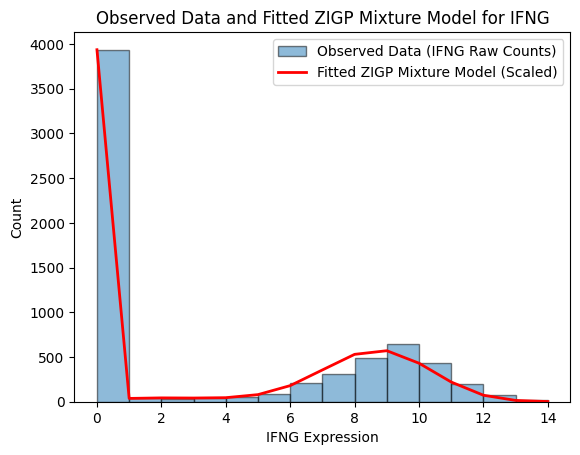


Processing gene: CD28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7495.7121922036295
            Iterations: 22
            Function evaluations: 203
            Gradient evaluations: 22
Final Log-Likelihood: -7495.7121922036295
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.726724275563507
Mixture Proportions (weights): [0.29208815 0.70791185]
Generalized Poisson Rates (lambdas): [ 2.10370273 14.72613656]
Dispersion Parameters (thetas): [ 0.19602785 -0.99      ]


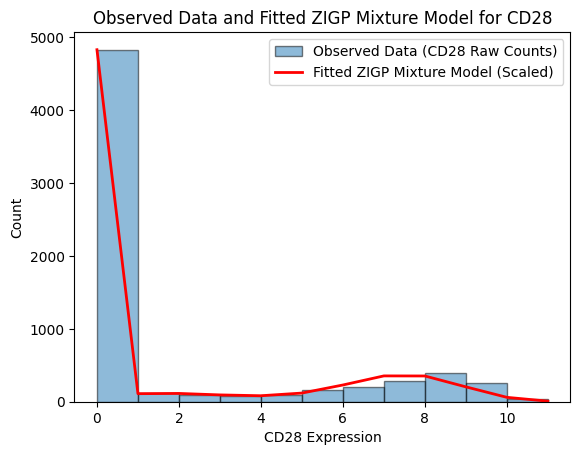


Processing gene: SLAMF6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7522.138108361572
            Iterations: 25
            Function evaluations: 228
            Gradient evaluations: 25
Final Log-Likelihood: -7522.138108361572
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7167537570968101
Mixture Proportions (weights): [0.23508474 0.76491526]
Generalized Poisson Rates (lambdas): [ 1.79946661 14.84693155]
Dispersion Parameters (thetas): [ 0.1519403 -0.99     ]


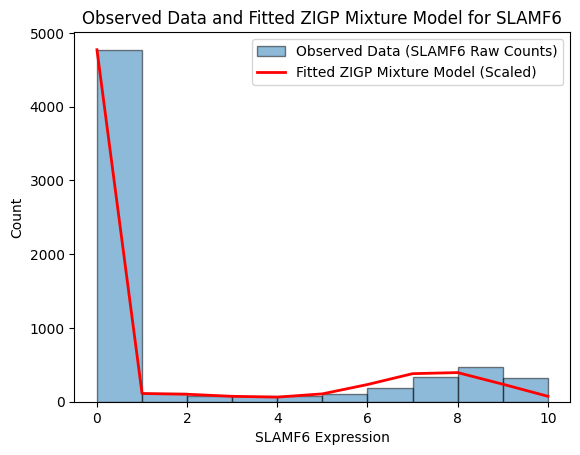


Finished processing all genes.


In [54]:
# Gene lists
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "BATF", "ENTPD1", "ITGAE", "LGALS9"]
progenitor_ex_genes = ["TCF7", "LEF1", "CXCR5", "IL7R", "SELL", "GZMB", "PRF1", "IFNG", "CD28", "SLAMF6"]

# Results storage
results = {}

# Fit the ZIGPM model for each gene in the terminal_ex_genes list
print("Fitting ZIGPM for terminal exhaustion genes...")
results["terminal_ex_genes"] = {}
for gene in terminal_ex_genes:
    print(f"\nProcessing gene: {gene}")
    try:
        results["terminal_ex_genes"][gene] = fit_zigp_mixture_model(cd8_adata, gene, M=2)
    except Exception as e:
        print(f"Failed to process {gene}: {e}")

# Fit the ZIGPM model for each gene in the progenitor_ex_genes list
print("\nFitting ZIGPM for progenitor exhaustion genes...")
results["progenitor_ex_genes"] = {}
for gene in progenitor_ex_genes:
    print(f"\nProcessing gene: {gene}")
    try:
        results["progenitor_ex_genes"][gene] = fit_zigp_mixture_model(cd8_adata, gene, M=2)
    except Exception as e:
        print(f"Failed to process {gene}: {e}")

# Display summary of results
print("\nFinished processing all genes.")


Fitting ZIGPM for terminal exhaustion genes...

Processing gene: TCF7


/usr4/spclpgm/myousry/.local/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 7606.798363331915
            Iterations: 24
            Function evaluations: 223
            Gradient evaluations: 24
Final Log-Likelihood: -7606.798363331915
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7197736857220035
Mixture Proportions (weights): [0.24818949 0.75181051]
Generalized Poisson Rates (lambdas): [ 3.20784966 12.62191543]
Dispersion Parameters (thetas): [ 0.00463488 -0.89785165]


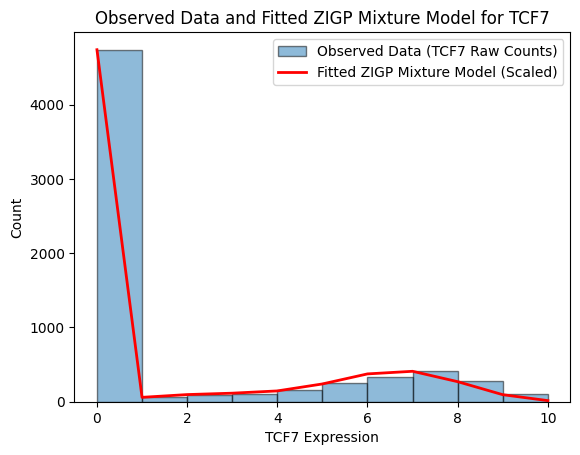


Processing gene: LEF1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2871.95785156294
            Iterations: 19
            Function evaluations: 173
            Gradient evaluations: 19
Final Log-Likelihood: -2871.95785156294
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.9227467995801202
Mixture Proportions (weights): [0.28071192 0.71928808]
Generalized Poisson Rates (lambdas): [ 3.44228891 15.94668036]
Dispersion Parameters (thetas): [ 0.0208723 -0.99     ]


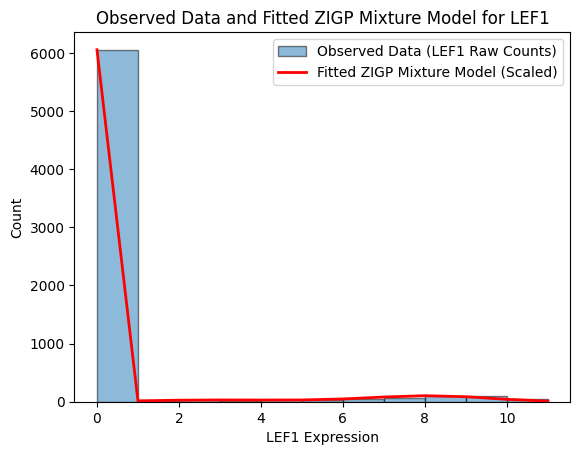


Processing gene: CXCR5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2844.7939318016533
            Iterations: 19
            Function evaluations: 168
            Gradient evaluations: 19
Final Log-Likelihood: -2844.7939318016533
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.9205477911710204
Mixture Proportions (weights): [0.4046043 0.5953957]
Generalized Poisson Rates (lambdas): [ 3.15679254 11.43837292]
Dispersion Parameters (thetas): [-0.02798369 -0.89867479]


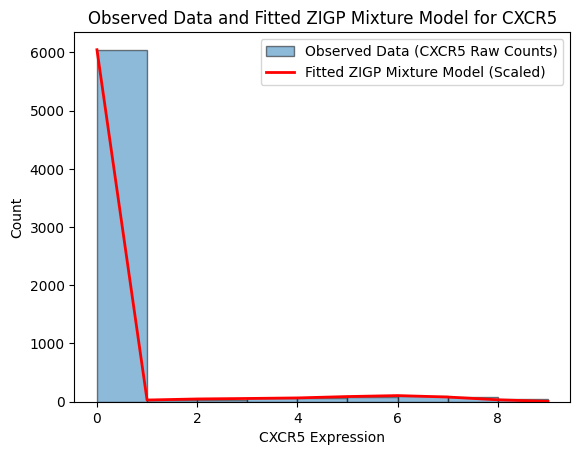


Processing gene: IL7R
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7741.67793326595
            Iterations: 29
            Function evaluations: 266
            Gradient evaluations: 29
Final Log-Likelihood: -7741.67793326595
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7157107175427464
Mixture Proportions (weights): [0.15142027 0.84857973]
Generalized Poisson Rates (lambdas): [ 3.43832409 16.70976121]
Dispersion Parameters (thetas): [ 0.09924324 -0.99      ]


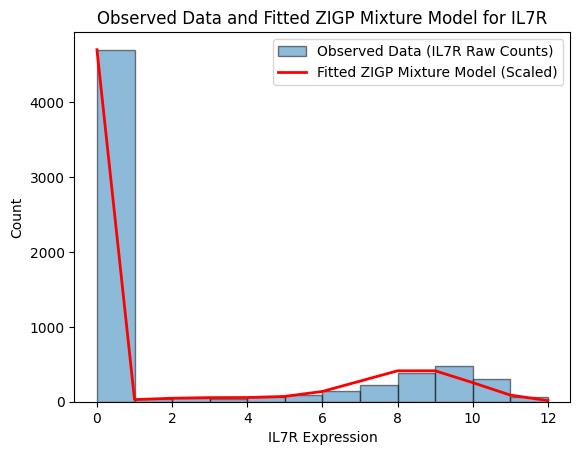


Processing gene: SELL
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5272.986991273605
            Iterations: 24
            Function evaluations: 220
            Gradient evaluations: 24
Final Log-Likelihood: -5272.986991273605
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.8280963815802942
Mixture Proportions (weights): [0.24053245 0.75946755]
Generalized Poisson Rates (lambdas): [ 1.86053349 16.86949499]
Dispersion Parameters (thetas): [ 0.11478073 -0.99      ]


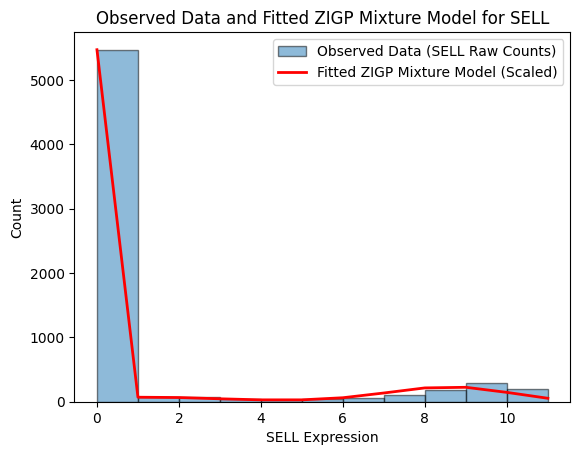


Processing gene: SLAMF6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7522.13811061957
            Iterations: 24
            Function evaluations: 222
            Gradient evaluations: 24
Final Log-Likelihood: -7522.13811061957
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7167220322900621
Mixture Proportions (weights): [0.23514396 0.76485604]
Generalized Poisson Rates (lambdas): [ 1.79827725 14.84685032]
Dispersion Parameters (thetas): [ 0.15227475 -0.99      ]


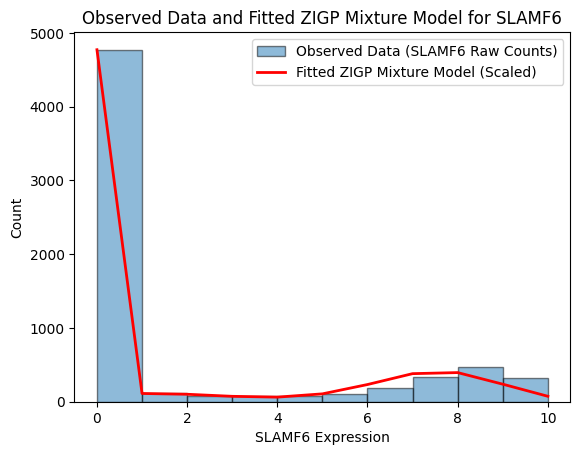


Processing gene: FOXP1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9934.862977663046
            Iterations: 22
            Function evaluations: 197
            Gradient evaluations: 22
Final Log-Likelihood: -9934.862977663046
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5992471171406332
Mixture Proportions (weights): [0.40996641 0.59003359]
Generalized Poisson Rates (lambdas): [ 3.18184535 13.53612526]
Dispersion Parameters (thetas): [-2.28792259e-04 -9.90000000e-01]


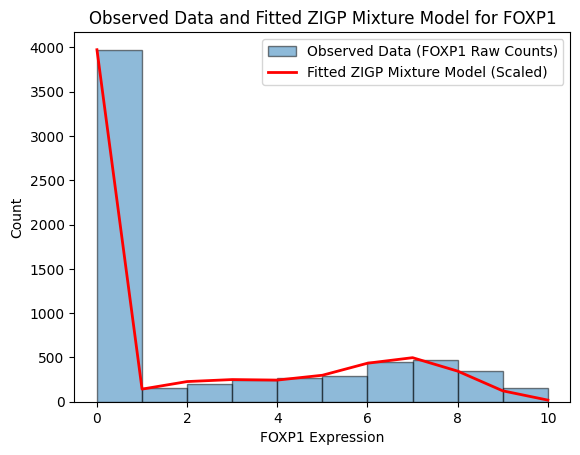


Processing gene: STAT4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12135.937396134632
            Iterations: 24
            Function evaluations: 222
            Gradient evaluations: 24
Final Log-Likelihood: -12135.937396134632
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.42886830551438826
Mixture Proportions (weights): [0.17708185 0.82291815]
Generalized Poisson Rates (lambdas): [ 4.4354171  15.61427806]
Dispersion Parameters (thetas): [-0.05141167 -0.99      ]


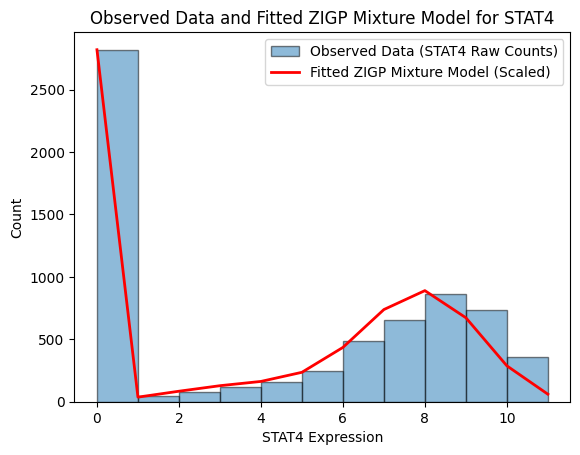


Processing gene: AIM1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7984.0532052276585
            Iterations: 21
            Function evaluations: 195
            Gradient evaluations: 21
Final Log-Likelihood: -7984.0532052276585
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7015405083122437
Mixture Proportions (weights): [0.34055968 0.65944032]
Generalized Poisson Rates (lambdas): [ 2.1587895  11.97195924]
Dispersion Parameters (thetas): [ 0.12486185 -0.79987069]


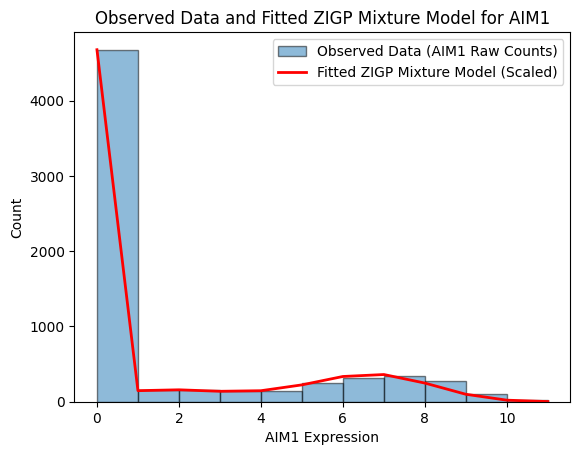


Processing gene: FOSL2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11284.431621081589
            Iterations: 21
            Function evaluations: 196
            Gradient evaluations: 21
Final Log-Likelihood: -11284.431621081589
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5087687274117639
Mixture Proportions (weights): [0.45301005 0.54698995]
Generalized Poisson Rates (lambdas): [ 2.44172442 13.8256058 ]
Dispersion Parameters (thetas): [ 0.09629549 -0.99      ]


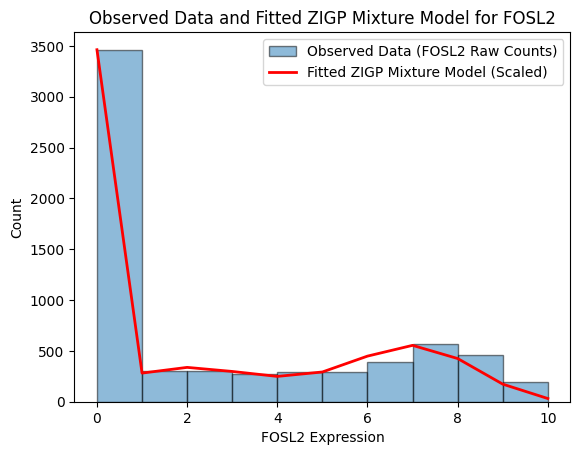


Fitting ZIGPM for progenitor exhaustion genes...

Processing gene: PDCD1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10297.24472460078
            Iterations: 26
            Function evaluations: 239
            Gradient evaluations: 26
Final Log-Likelihood: -10297.24472460078
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5209438251959612
Mixture Proportions (weights): [0.11212966 0.88787034]
Generalized Poisson Rates (lambdas): [ 1.21832439 16.43125733]
Dispersion Parameters (thetas): [ 0.26092375 -0.99      ]


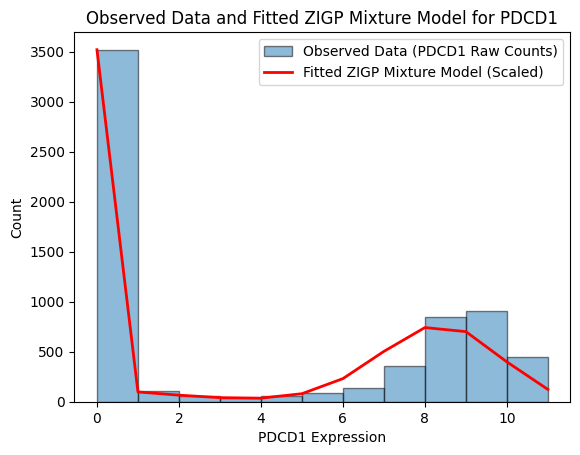


Processing gene: LAG3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9588.666957681859
            Iterations: 24
            Function evaluations: 219
            Gradient evaluations: 24
Final Log-Likelihood: -9588.666957681859
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5959221036498987
Mixture Proportions (weights): [0.18219164 0.81780836]
Generalized Poisson Rates (lambdas): [ 2.10969611 13.89718972]
Dispersion Parameters (thetas): [ 0.10974055 -0.99      ]


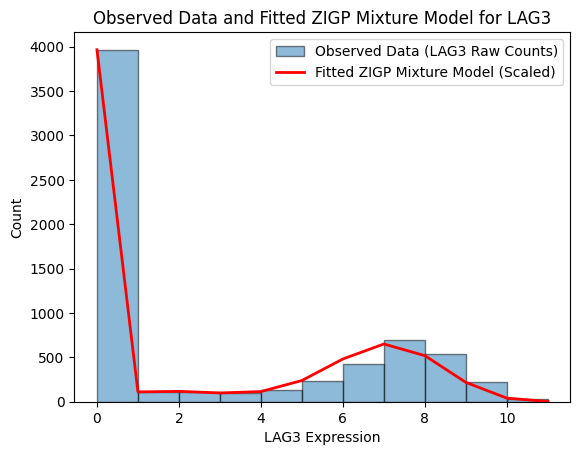


Processing gene: HAVCR2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9947.057884182132
            Iterations: 28
            Function evaluations: 251
            Gradient evaluations: 27
Final Log-Likelihood: -9947.057884182132
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5779552401769563
Mixture Proportions (weights): [0.11269333 0.88730667]
Generalized Poisson Rates (lambdas): [ 2.77975452 16.81837481]
Dispersion Parameters (thetas): [-0.05262562 -0.99      ]


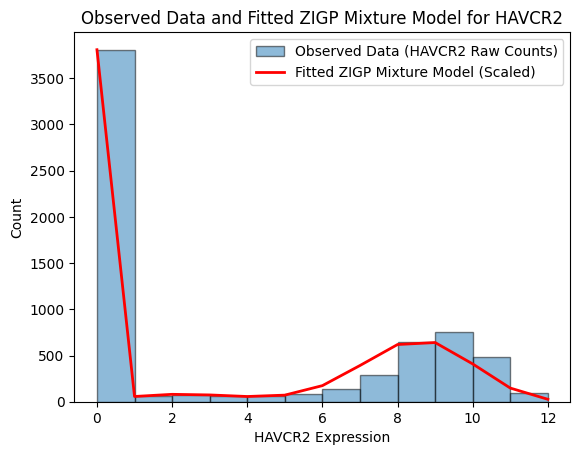


Processing gene: TIGIT
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10891.215281186931
            Iterations: 28
            Function evaluations: 256
            Gradient evaluations: 28
Final Log-Likelihood: -10891.215281186931
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.47541705363165276
Mixture Proportions (weights): [0.05757684 0.94242316]
Generalized Poisson Rates (lambdas): [ 2.53453897 16.49846379]
Dispersion Parameters (thetas): [ 0.0134773 -0.99     ]


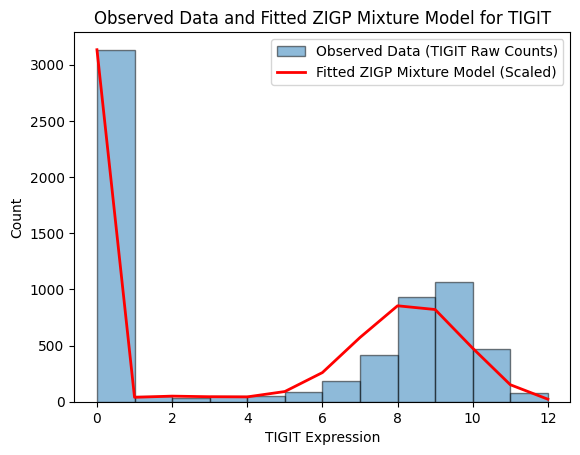


Processing gene: TOX
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10560.917459160555
            Iterations: 23
            Function evaluations: 212
            Gradient evaluations: 23
Final Log-Likelihood: -10560.917459160555
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5493905530743192
Mixture Proportions (weights): [0.34706571 0.65293429]
Generalized Poisson Rates (lambdas): [ 2.896189   13.11693454]
Dispersion Parameters (thetas): [-5.13774836e-04 -9.89999991e-01]


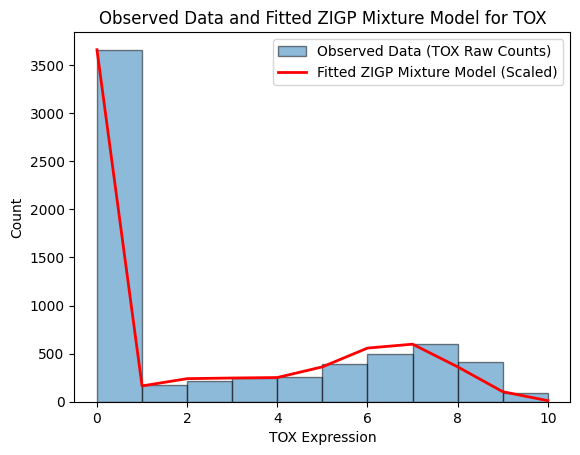


Processing gene: EOMES
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6711.12629852925
            Iterations: 20
            Function evaluations: 187
            Gradient evaluations: 20
Final Log-Likelihood: -6711.12629852925
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7682463540843785
Mixture Proportions (weights): [0.39823997 0.60176003]
Generalized Poisson Rates (lambdas): [ 4.25003616 13.25029507]
Dispersion Parameters (thetas): [-0.07279756 -0.94661968]


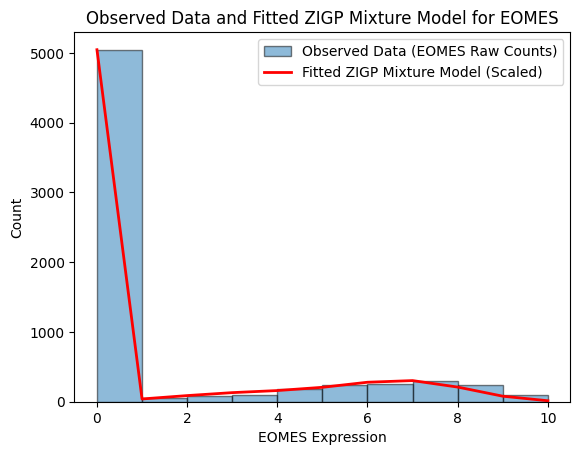


Processing gene: ENTPD1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7705.750059081906
            Iterations: 25
            Function evaluations: 225
            Gradient evaluations: 25
Final Log-Likelihood: -7705.750059081906
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7201579775072949
Mixture Proportions (weights): [0.23235615 0.76764385]
Generalized Poisson Rates (lambdas): [ 3.28507871 15.16510902]
Dispersion Parameters (thetas): [ 0.03938773 -0.99      ]


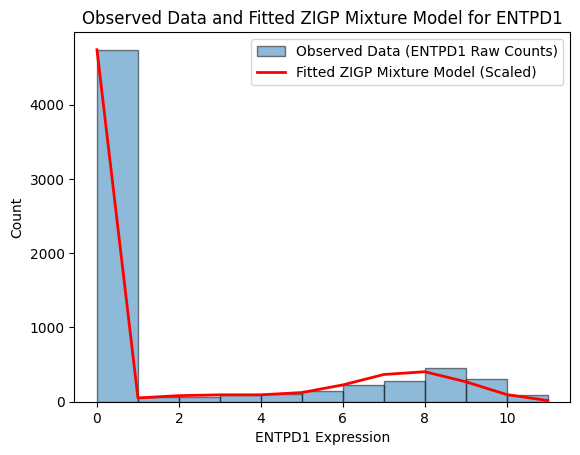


Processing gene: BATF
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8161.563053298104
            Iterations: 24
            Function evaluations: 221
            Gradient evaluations: 24
Final Log-Likelihood: -8161.563053298104
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.688596368976032
Mixture Proportions (weights): [0.17502077 0.82497923]
Generalized Poisson Rates (lambdas): [ 2.94776435 16.01749596]
Dispersion Parameters (thetas): [-0.23418542 -0.99      ]


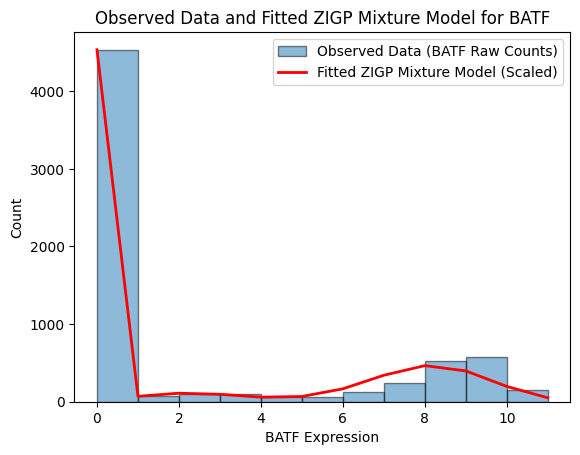


Processing gene: LGALS9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5685.191442093297
            Iterations: 23
            Function evaluations: 206
            Gradient evaluations: 23
Final Log-Likelihood: -5685.191442093297
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.8096954139106135
Mixture Proportions (weights): [0.18125081 0.81874919]
Generalized Poisson Rates (lambdas): [ 4.08351065 14.55604131]
Dispersion Parameters (thetas): [-0.1377312 -0.99     ]


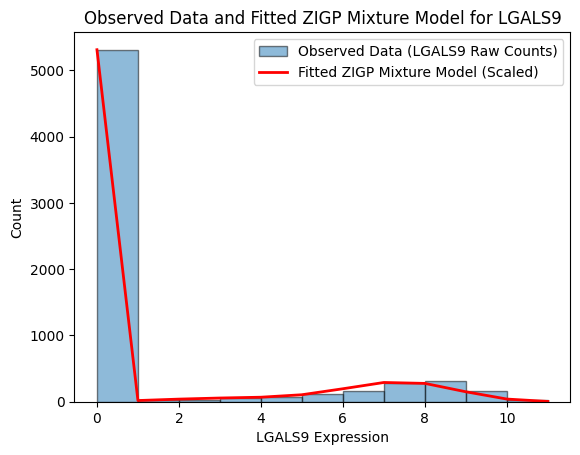


Processing gene: CD38
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9177.212707636367
            Iterations: 29
            Function evaluations: 249
            Gradient evaluations: 29
Final Log-Likelihood: -9177.212707636367
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.6303118763256687
Mixture Proportions (weights): [0.15879648 0.84120352]
Generalized Poisson Rates (lambdas): [ 2.4865769  15.79803294]
Dispersion Parameters (thetas): [-0.01455492 -0.99      ]


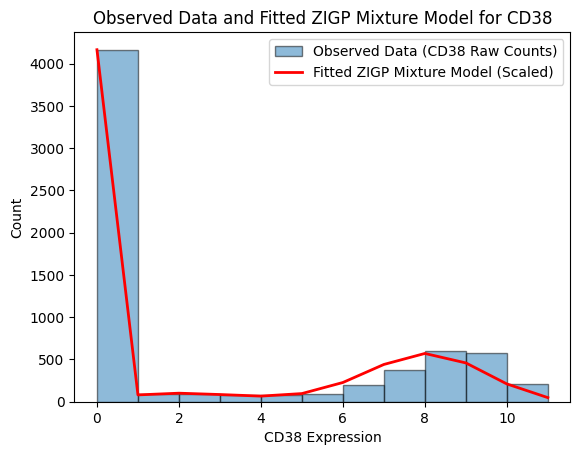


Finished processing all genes.


In [7]:
# Gene lists
progenitor_ex_genes = ["TCF7", "LEF1", "CXCR5", "IL7R", "SELL", "SLAMF6", "FOXP1", "STAT4", "AIM1", "FOSL2"]
terminal_ex_genes = ["PDCD1", "LAG3", "HAVCR2", "TIGIT", "TOX", "EOMES", "ENTPD1", "BATF", "LGALS9", "CD38"]

# Results storage
results = {}

# Fit the ZIGPM model for each gene in the terminal_ex_genes list
print("Fitting ZIGPM for terminal exhaustion genes...")
results["terminal_ex_genes"] = {}
for gene in terminal_ex_genes:
    print(f"\nProcessing gene: {gene}")
    try:
        results["terminal_ex_genes"][gene] = fit_zigp_mixture_model(cd8_adata, gene, M=2)
    except Exception as e:
        print(f"Failed to process {gene}: {e}")

# Fit the ZIGPM model for each gene in the progenitor_ex_genes list
print("\nFitting ZIGPM for progenitor exhaustion genes...")
results["progenitor_ex_genes"] = {}
for gene in progenitor_ex_genes:
    print(f"\nProcessing gene: {gene}")
    try:
        results["progenitor_ex_genes"][gene] = fit_zigp_mixture_model(cd8_adata, gene, M=2)
    except Exception as e:
        print(f"Failed to process {gene}: {e}")

# Display summary of results
print("\nFinished processing all genes.")


## Cell State Probability Distribution

### Mixture Beta Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

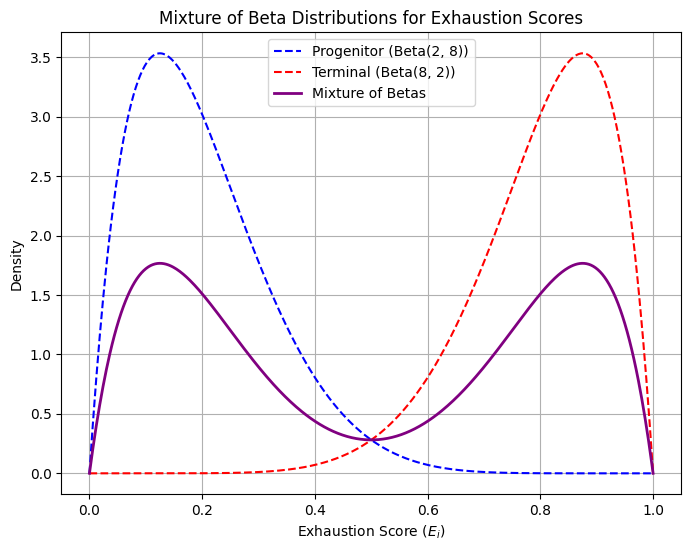

In [2]:
# Parameters for the mixture of Beta distributions
alpha_1, beta_1 = 2, 8  # Progenitor exhausted
alpha_2, beta_2 = 8, 2  # Terminally exhausted

# Mixture weight
w = 0.5  # Equal mixture weight

# Define the range for exhaustion scores
x = np.linspace(0, 1, 500)

# Compute the Beta distributions
beta_1_pdf = beta.pdf(x, alpha_1, beta_1)
beta_2_pdf = beta.pdf(x, alpha_2, beta_2)

# Compute the mixture of Betas
mixture_pdf = w * beta_1_pdf + (1 - w) * beta_2_pdf

# Plot the distributions
plt.figure(figsize=(8, 6))
plt.plot(x, beta_1_pdf, label=f"Progenitor (Beta({alpha_1}, {beta_1}))", linestyle="--", color="blue")
plt.plot(x, beta_2_pdf, label=f"Terminal (Beta({alpha_2}, {beta_2}))", linestyle="--", color="red")
plt.plot(x, mixture_pdf, label="Mixture of Betas", color="purple", linewidth=2)
plt.title("Mixture of Beta Distributions for Exhaustion Scores")
plt.xlabel("Exhaustion Score ($E_i$)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

### Gamma Hyperpriors

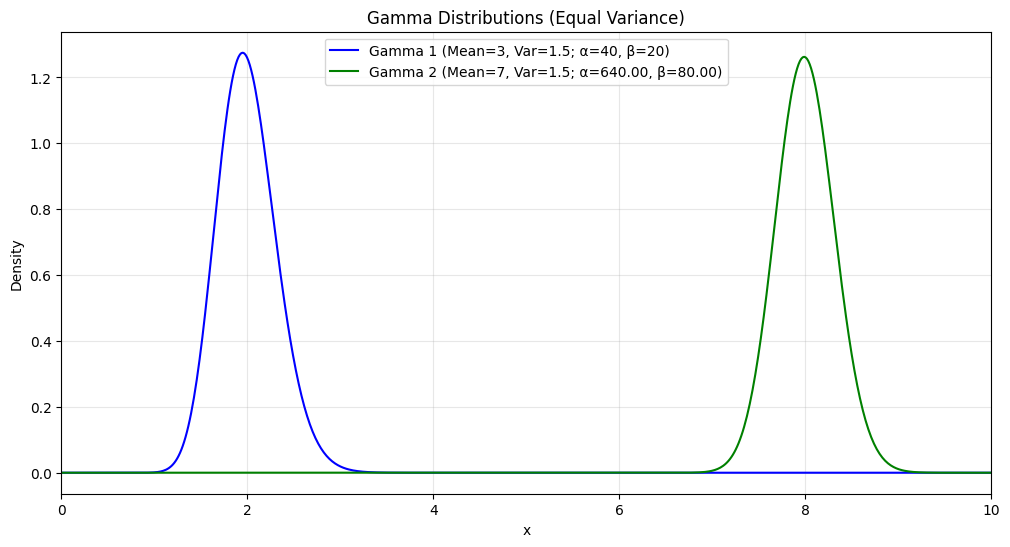

In [4]:
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

# Define Gamma parameters
alpha_1, beta_1 = 40, 20
alpha_2, beta_2 = 640, 80

# Generate x values
x = np.linspace(0, 15, 1000)

# Compute PDFs
pdf_gamma_1 = gamma.pdf(x, a=alpha_1, scale=1 / beta_1)
pdf_gamma_2 = gamma.pdf(x, a=alpha_2, scale=1 / beta_2)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, pdf_gamma_1, label=f"Gamma 1 (Mean=3, Var=1.5; α={alpha_1}, β={beta_1})", color="blue")
plt.plot(x, pdf_gamma_2, label=f"Gamma 2 (Mean=7, Var=1.5; α={alpha_2:.2f}, β={beta_2:.2f})", color="green")
plt.title("Gamma Distributions (Equal Variance)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, 10)
plt.show()
